# 🌡️ ERA5 Diagnostics and Anomaly Mapping for 29 July 2024
This notebook performs the following steps:
- Compute daily mean from hourly ERA5 GRIB data (29 July 2024)
- Extract and calculate diagnostics:
  - Vertical velocity (500 hPa)
  - Moisture flux convergence (850 hPa)
  - Vertically Integrated Moisture Flux Convergence (VIMFC)
  - Wind shear (850–200 hPa)
  - Moist Static Energy (MSE, 850 hPa)
- Compare with July monthly mean (ERA5)
- Plot anomalies and export GeoTIFFs

In [1]:

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import geocat.comp as gc
#import geocat.datafiles as gcd


In [10]:
def plot_variable_with_shapefiles(
    data, lon, lat, title, units, ax=None,
    cmap="RdBu_r", levels=21, shapefiles=None,
    extent=[65, 85, 0, 20], add_colorbar=True
):
    """
    Plots an ERA5 variable with shapefile overlay on a given axis (ax).

    Parameters:
        data : 2D numpy array
        lon, lat : 1D or 2D longitude/latitude arrays
        title : str
        units : str
        ax : matplotlib Axes (with Cartopy) — required for subplots
        cmap : str or Colormap
        levels : int or list of contour levels
        shapefiles : list of GeoDataFrames
        extent : [lon_min, lon_max, lat_min, lat_max]
        add_colorbar : bool (to control per-subplot or global colorbar)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    cf = ax.contourf(
        lon, lat, data,
        levels=levels,
        cmap=cmap,
        extend='both',
        transform=ccrs.PlateCarree()
    )

    if shapefiles:
        for shp in shapefiles:
            shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(title, fontsize=20)

    # Gridlines and ticks
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.xlocator = plt.FixedLocator(np.arange(extent[0], extent[1]+1, 5))
    gl.ylocator = plt.FixedLocator(np.arange(extent[2], extent[3]+1, 5))

    if add_colorbar:
        cbar = plt.colorbar(cf, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
        cbar.set_label(units)

    return cf  # so you can add a shared colorbar if needed


In [11]:
# Load shapefiles
wg = gpd.read_file("/Users/subin/Downloads/Shape_files/wg_bnd/wg_bnd.shp")  # Western Ghats or region boundary
world = gpd.read_file("/Users/subin/Downloads/Shape_files/world_boundaries/World_Countries_shp.shp")

# Ensure shapefiles are in WGS84
wg = wg.to_crs("EPSG:4326")
world = world.to_crs("EPSG:4326")

# Define bounding box: (minx, miny, maxx, maxy) = (lon_min, lat_min, lon_max, lat_max)
bbox = (65, 0, 85, 20)

# Clip using GeoDataFrame's .cx spatial indexer
world_clipped = world.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

In [12]:

# Define paths to files
file_hourly = "ERA5_29July2024.grib"
file_monthly = "ERA5_July_clim.grib"
file_monthly_1 = "ERA5_July_Clim_Div_Vorticity.grib"

# Open datasets (cfgrib engine must be installed)
ds_hourly = xr.open_dataset(file_hourly, engine="cfgrib")
ds_monthly = xr.open_dataset(file_monthly, engine="cfgrib")
ds_monthly_1 = xr.open_dataset(file_monthly_1, engine="cfgrib")


In [13]:

# Average hourly data into daily mean
ds_daily = ds_hourly.mean(dim="time")
ds_monthly = ds_monthly.mean(dim="time") # to remove time dimension
ds_monthly_1 = ds_monthly_1.mean(dim="time") # to remove time dimension

In [14]:

# Extract variables at key levels from daily data
plev = ds_hourly['isobaricInhPa'].values

def sel_level(ds, varname, level):
    return ds[varname].sel(isobaricInhPa=level, method='nearest')

t_850 = sel_level(ds_daily, 't', 850)
q_850 = sel_level(ds_daily, 'q', 850)
z_850 = sel_level(ds_daily, 'z', 850)
w_500 = sel_level(ds_daily, 'w', 500)
u_850 = sel_level(ds_daily, 'u', 850)
v_850 = sel_level(ds_daily, 'v', 850)
u_200 = sel_level(ds_daily, 'u', 200)
v_200 = sel_level(ds_daily, 'v', 200)



In [15]:
# Extract variables at key levels from Monthly data
t_850_m = sel_level(ds_monthly, 't', 850)
q_850_m = sel_level(ds_monthly, 'q', 850)
z_850_m = sel_level(ds_monthly, 'z', 850)
w_500_m = sel_level(ds_monthly, 'w', 500)
u_850_m = sel_level(ds_monthly, 'u', 850)
v_850_m = sel_level(ds_monthly, 'v', 850)
u_200_m = sel_level(ds_monthly, 'u', 200)
v_200_m = sel_level(ds_monthly, 'v', 200)


In [16]:
lat = ds_monthly.latitude.values
lon = ds_monthly.longitude.values

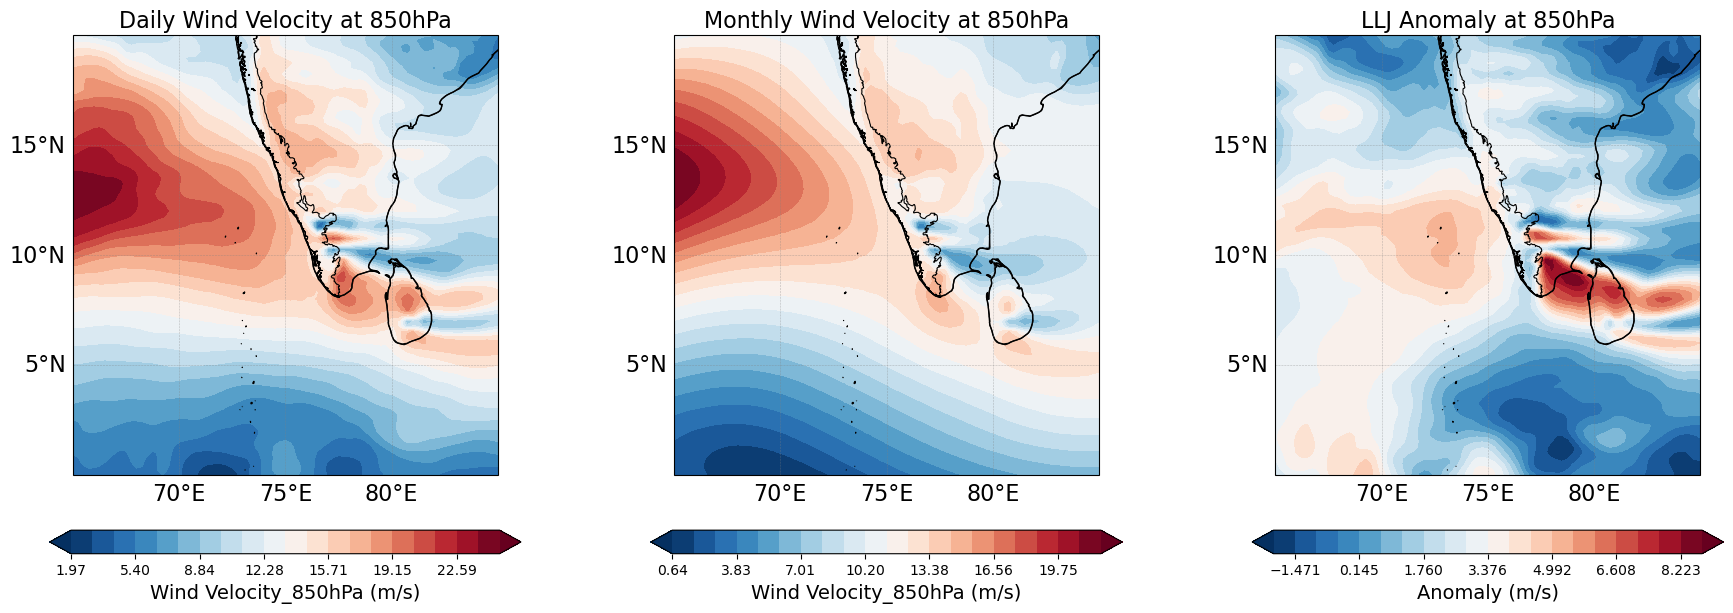

In [19]:
#LLJ anomaly
llj = np.sqrt(u_850**2 + v_850**2)
llj_m = np.sqrt(u_850_m**2 + v_850_m**2)
# anomaly
llj_ano = llj - llj_m

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(llj, lon, lat, "Daily Wind Velocity at 850hPa", "m/s", ax=axs[0],
                                    levels=np.linspace(np.min(llj), np.max(llj), 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(llj_m, lon, lat, "Monthly Wind Velocity at 850hPa", "m/s", ax=axs[1],
                                    levels=np.linspace(np.min(llj_m), np.max(llj_m), 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(llj_ano, lon, lat, "LLJ Anomaly at 850hPa", "m/s", ax=axs[2],
                                    levels=np.linspace(np.min(llj_ano), np.max(llj_ano), 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Wind Velocity_850hPa (m/s)", fontsize = 14)
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Wind Velocity_850hPa (m/s)", fontsize = 14)
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly (m/s)", fontsize = 14)
plt.savefig("Wind Velocity_850hPa.png", dpi=300, bbox_inches='tight')
plt.show()

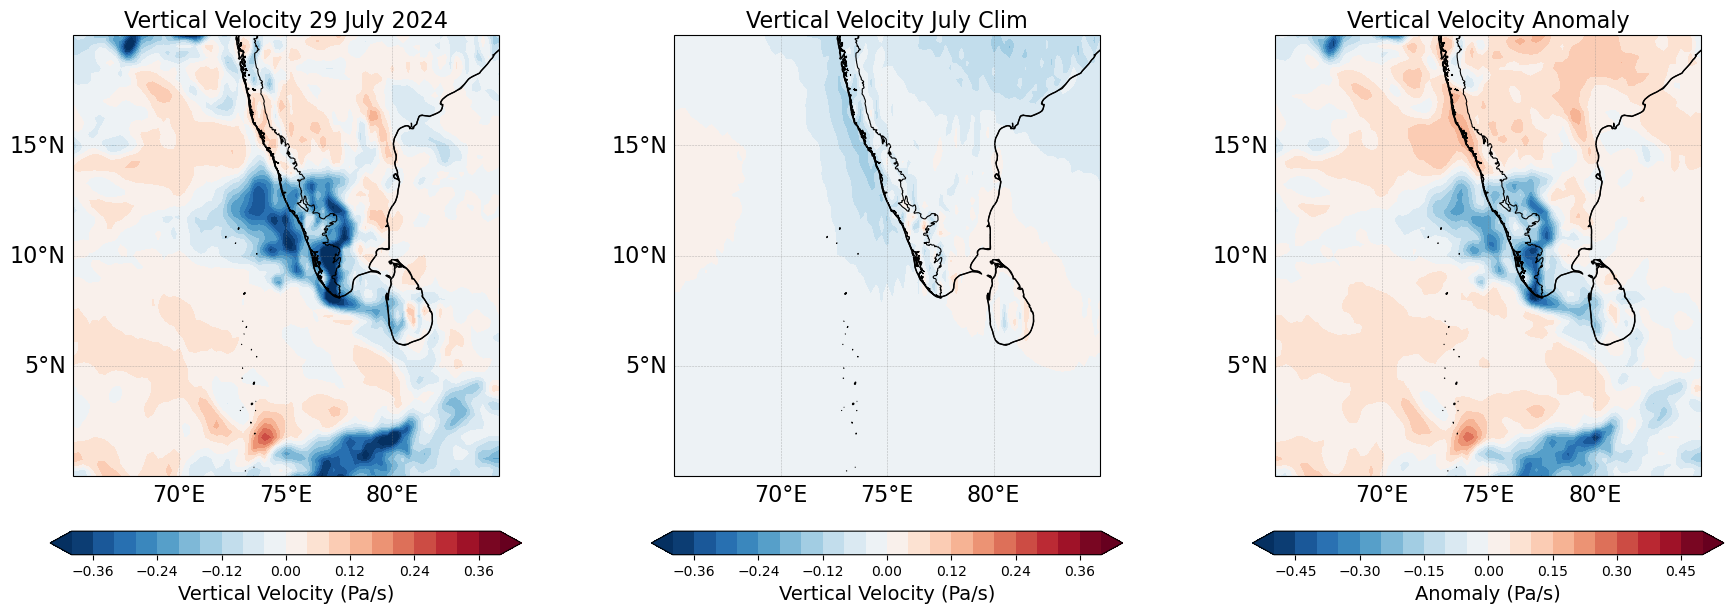

In [20]:
#Vertical Velocity (500 hPa)

# Anomaly
w_500_ano = w_500 - w_500_m

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(w_500, lon, lat, "Vertical Velocity 29 July 2024", "Pa/s", ax=axs[0],
                                    levels=np.linspace(-0.4,0.4, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(w_500_m, lon, lat, "Vertical Velocity July Clim", "Pa/s", ax=axs[1],
                                    levels=np.linspace(-0.4,0.4, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(w_500_ano, lon, lat, "Vertical Velocity Anomaly", "Pa/s", ax=axs[2],
                                    levels=np.linspace(-0.5,0.5, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Vertical Velocity (Pa/s)",fontsize = 14)
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Vertical Velocity (Pa/s)",fontsize = 14)
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly (Pa/s)",fontsize = 14)
plt.savefig("Vertical Velocity.png", dpi=300, bbox_inches='tight')
plt.show()


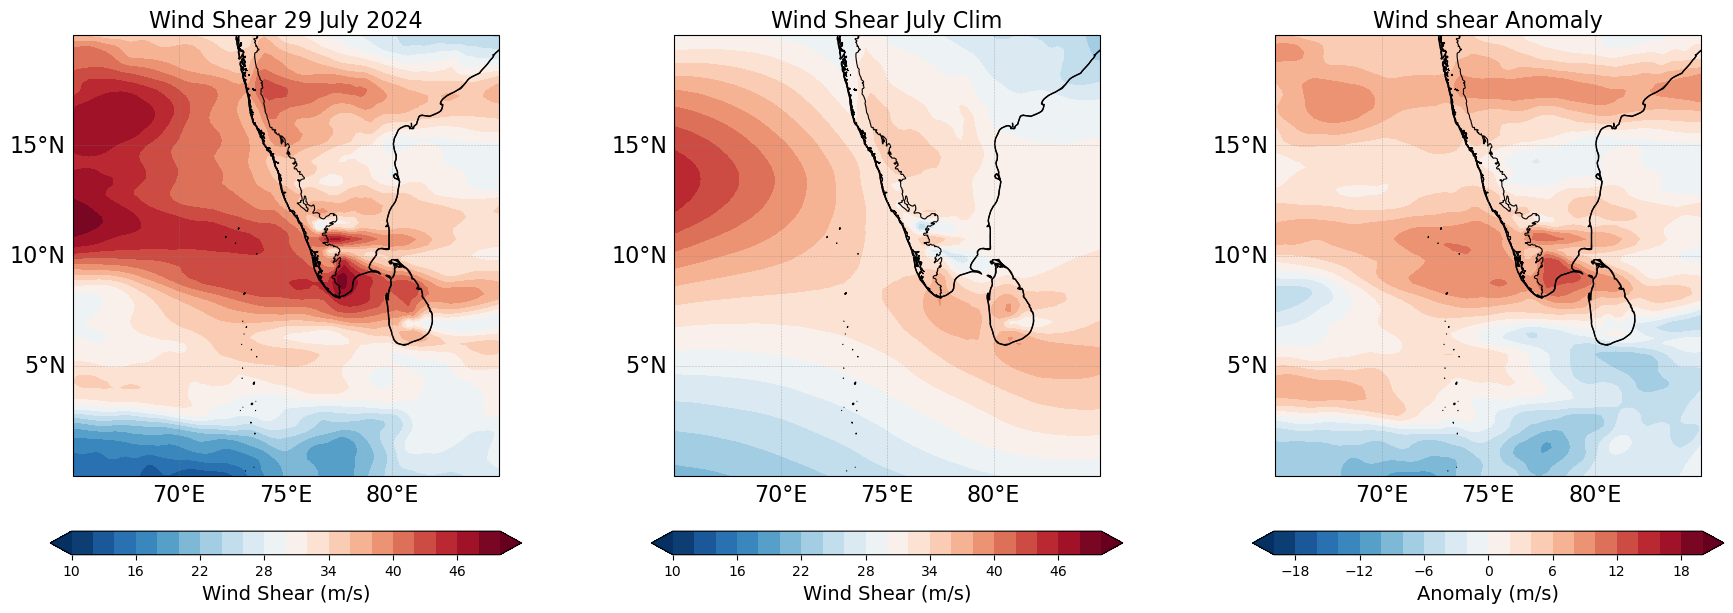

In [21]:
wind_shear = np.sqrt((u_200 - u_850)**2 + (v_200 - v_850)**2)
wind_shear_m = np.sqrt((u_200_m - u_850_m)**2 + (v_200_m - v_850_m)**2)
# Anomaly
wind_shear_ano = wind_shear - wind_shear_m

# Plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(wind_shear, lon, lat, "Wind Shear 29 July 2024", "m/s",ax=axs[0],
                                    levels=np.linspace(10,50, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(wind_shear_m, lon, lat, "Wind Shear July Clim", "m/s", ax=axs[1],
                                    levels=np.linspace(10,50, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(wind_shear_ano, lon, lat, "Wind shear Anomaly", "m/s", ax=axs[2],
                                    levels=np.linspace(-20,20, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Wind Shear (m/s)", fontsize = 14)
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Wind Shear (m/s)", fontsize = 14)
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly (m/s)", fontsize = 14)
plt.savefig("Wind Shear.png", dpi=300, bbox_inches='tight')
plt.show()


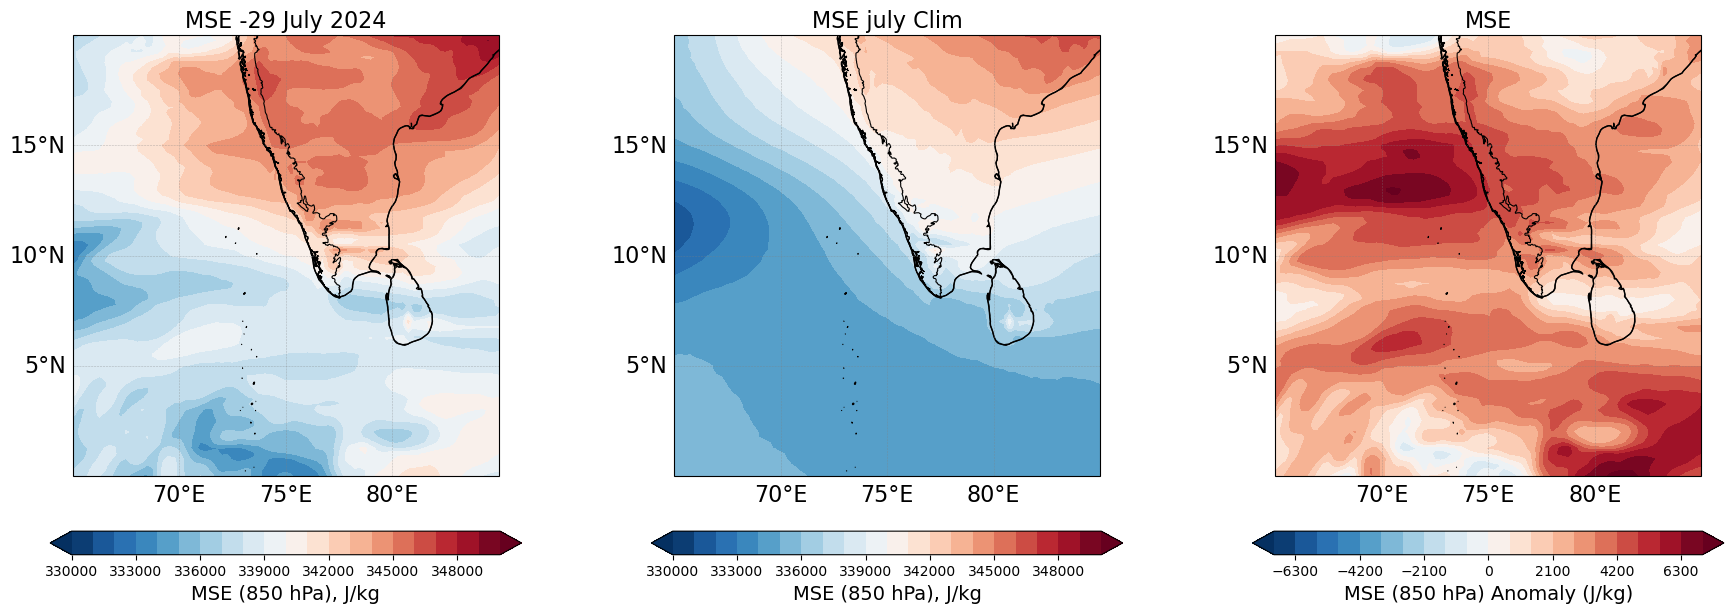

In [22]:
#Moist Static Energy (MSE) at 850 hPa

# Convert geopotential to height
g = 9.81
z_m_850 = z_850 / g

# Compute MSE on 29 july2024
cp = 1004  # J/kg/K
Lv = 2.5e6  # J/kg
mse_850 = cp * t_850 + Lv * q_850 + g * z_m_850

z_m_850_m = z_850_m / g
mse_850_m = cp * t_850_m + Lv * q_850_m + g * z_m_850_m

# Anomaly
mse_ano = mse_850 - mse_850_m

# Plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(mse_850, lon, lat, "MSE -29 July 2024", "J/kg",ax=axs[0],
                                    levels=np.linspace(330000,350000, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(mse_850_m, lon, lat, "MSE july Clim", "J/kg", ax=axs[1],
                                    levels=np.linspace(330000,350000, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(mse_ano, lon, lat, "MSE", "J/kg", ax=axs[2],
                                    levels=np.linspace(-7000,7000, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("MSE (850 hPa), J/kg", fontsize = 14)
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("MSE (850 hPa), J/kg",fontsize = 14)
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("MSE (850 hPa) Anomaly (J/kg)", fontsize = 14)
plt.savefig("Moist Static Energy.png", dpi=300, bbox_inches='tight')
plt.show()

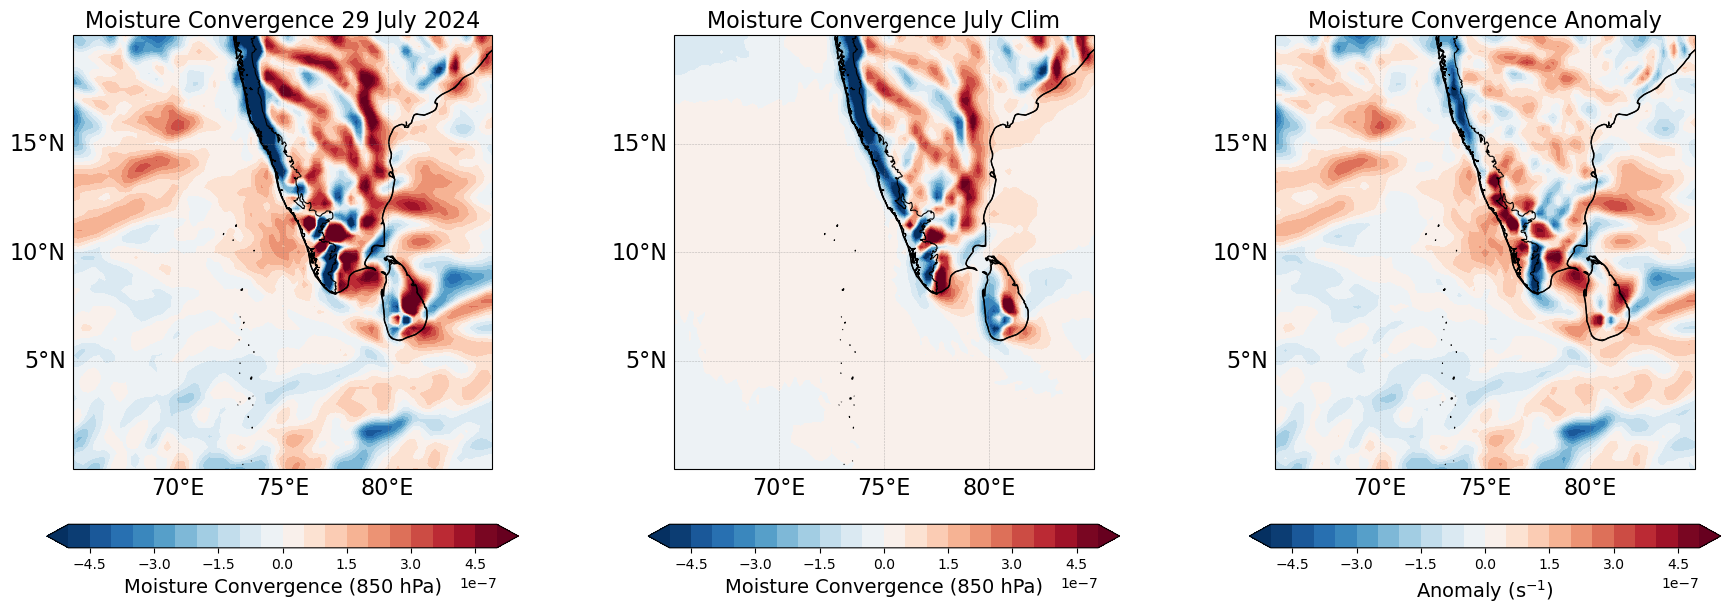

In [24]:
#moisture_convergence 29July2024
mf_u = q_850 * u_850
mf_v = q_850 * v_850

Re = 6.371e6
dlat = np.deg2rad(lat[1] - lat[0])
dlon = np.deg2rad(lon[1] - lon[0])
dx = Re * dlon * np.cos(np.deg2rad(lat))[:, np.newaxis]
dy = Re * dlat

d_mf_u_dx = np.gradient(mf_u, axis=1) / dx
d_mf_v_dy = np.gradient(mf_v, axis=0) / dy
moisture_convergence = -(d_mf_u_dx + d_mf_v_dy)

#moisture_convergence July2024
mf_u_m = q_850_m * u_850_m
mf_v_m = q_850_m * v_850_m

d_mf_u_dx_m = np.gradient(mf_u_m, axis=1) / dx
d_mf_v_dy_m = np.gradient(mf_v_m, axis=0) / dy
moisture_convergence_m = -(d_mf_u_dx_m + d_mf_v_dy_m)

#moisture_convergence anomaly

moisture_convergence_ano = moisture_convergence - moisture_convergence_m

# Plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(moisture_convergence, lon, lat, "Moisture Convergence 29 July 2024", "s$^-1$",ax=axs[0],
                                    levels=np.linspace(-0.5e-6,0.5e-6, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(moisture_convergence_m, lon, lat, "Moisture Convergence July Clim", "s$^-1$", ax=axs[1],
                                    levels=np.linspace(-0.5e-6,0.5e-6, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(moisture_convergence_ano, lon, lat, "Moisture Convergence Anomaly", "s$^-1$", ax=axs[2],
                                    levels=np.linspace(-5e-7,5e-7, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Moisture Convergence (850 hPa)",fontsize = 14)
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Moisture Convergence (850 hPa)",fontsize = 14)
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly (s$^{-1}$)",fontsize = 14)
plt.savefig("Moisture Convergence @ 850 hPa.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:

def compute_vimfc(ds, pmin=200, pmax=1000, g=9.80665):
    """
    Estimate Vertically Integrated Moisture Flux Convergence (VIMFC)
    from an xarray Dataset containing specific humidity, u and v winds.

    Parameters:
    ----------
    ds : xarray.Dataset
        Must contain 'q', 'u', 'v', and 'isobaricInhPa' dimensions.
    pmin, pmax : int
        Pressure bounds in hPa for integration (default: 200–1000 hPa).
    g : float
        Acceleration due to gravity (default: 9.80665 m/s²).

    Returns:
    -------
    xarray.DataArray
        2D VIMFC field (lat x lon) in units of kg/m²/s
    """

    # Select pressure levels and convert to Pa
    plevs = ds['isobaricInhPa'].values
    valid_levels = plevs[(plevs >= pmin) & (plevs <= pmax)]
    delta_p = np.gradient(valid_levels) * 100  # hPa → Pa
    delta_p = delta_p[:, None, None]  # shape: [level, 1, 1]

    # Extract coordinates
    lon = ds.longitude
    lat = ds.latitude

    # Initialize accumulator
    vimfc_sum = 0

    for i, p in enumerate(valid_levels):
        # 2D fields at level p
        q = ds['q'].sel(isobaricInhPa=p)
        u = ds['u'].sel(isobaricInhPa=p)
        v = ds['v'].sel(isobaricInhPa=p)

        # Moisture flux components
        q_u = (q * u).assign_coords({"longitude": lon, "latitude": lat})
        q_v = (q * v).assign_coords({"longitude": lon, "latitude": lat})

        # Compute gradients
        dq_u_dx, _ = gc.gradient(q_u, lon=lon, lat=lat)
        _, dq_v_dy = gc.gradient(q_v, lon=lon, lat=lat)

        # Horizontal convergence at this level
        convergence = dq_u_dx + dq_v_dy

        # Add to integrated sum
        vimfc_sum += convergence * delta_p[i]

    # Final VIMFC field
    vimfc = vimfc_sum / g
    vimfc.name = "VIMFC"
    vimfc.attrs['units'] = "kg m**-2 s**-1"
    vimfc.attrs['long_name'] = "Vertically Integrated Moisture Flux Convergence"

    return vimfc


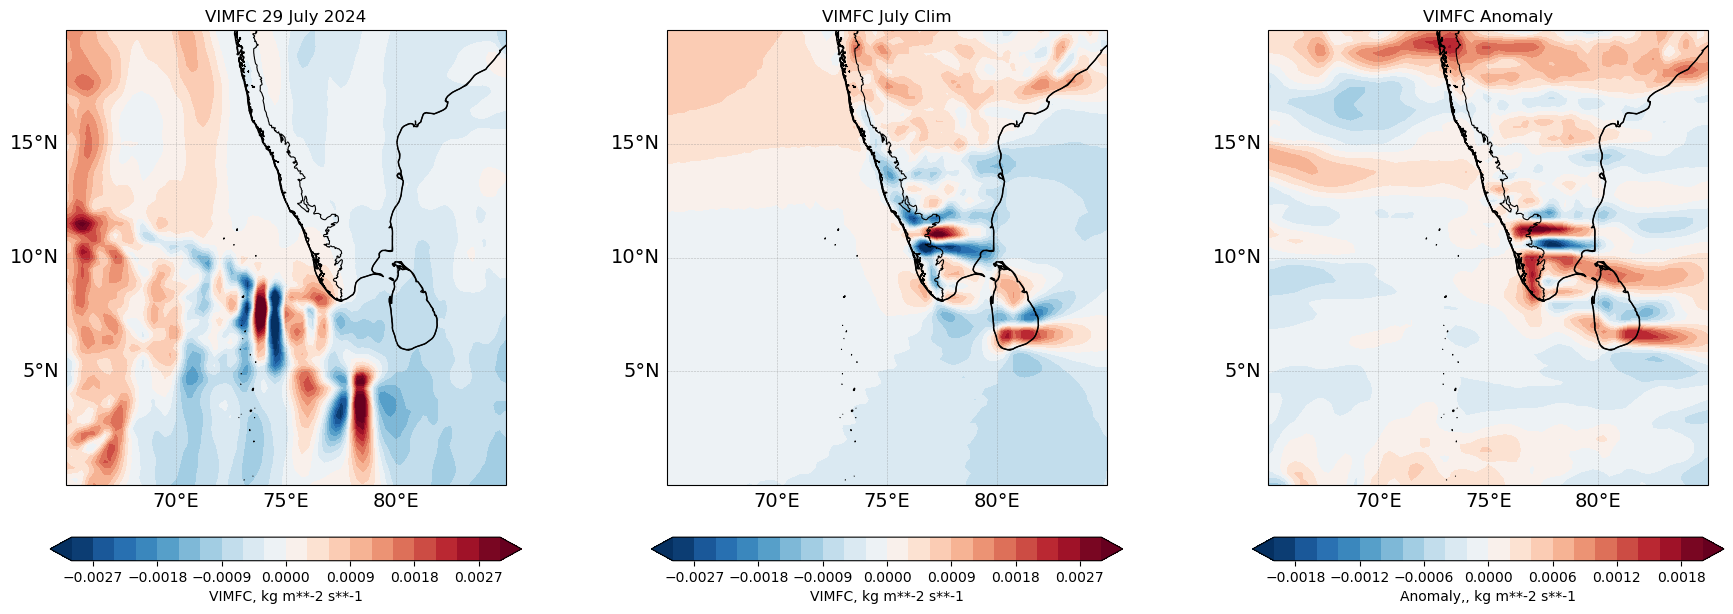

In [15]:
vimfc = compute_vimfc(ds_daily)
vimfc_m = compute_vimfc(ds_monthly)
vimfc_ano = vimfc - vimfc_m
# Plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(vimfc.T, lon, lat, "VIMFC 29 July 2024", "kg m**-2 s**-1",ax=axs[0],
                                    levels=np.linspace(-0.003,0.003, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(vimfc_m, lon, lat, "VIMFC July Clim", "kg m**-2 s**-1", ax=axs[1],
                                    levels=np.linspace(-0.003,0.003, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(vimfc_ano, lon, lat, "VIMFC Anomaly", "kg m**-2 s**-1", ax=axs[2],
                                    levels=np.linspace(-0.002,0.002, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("VIMFC, kg m**-2 s**-1")
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("VIMFC, kg m**-2 s**-1")
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly,, kg m**-2 s**-1")
plt.savefig("VIMFC.png", dpi=300, bbox_inches='tight')
plt.show()

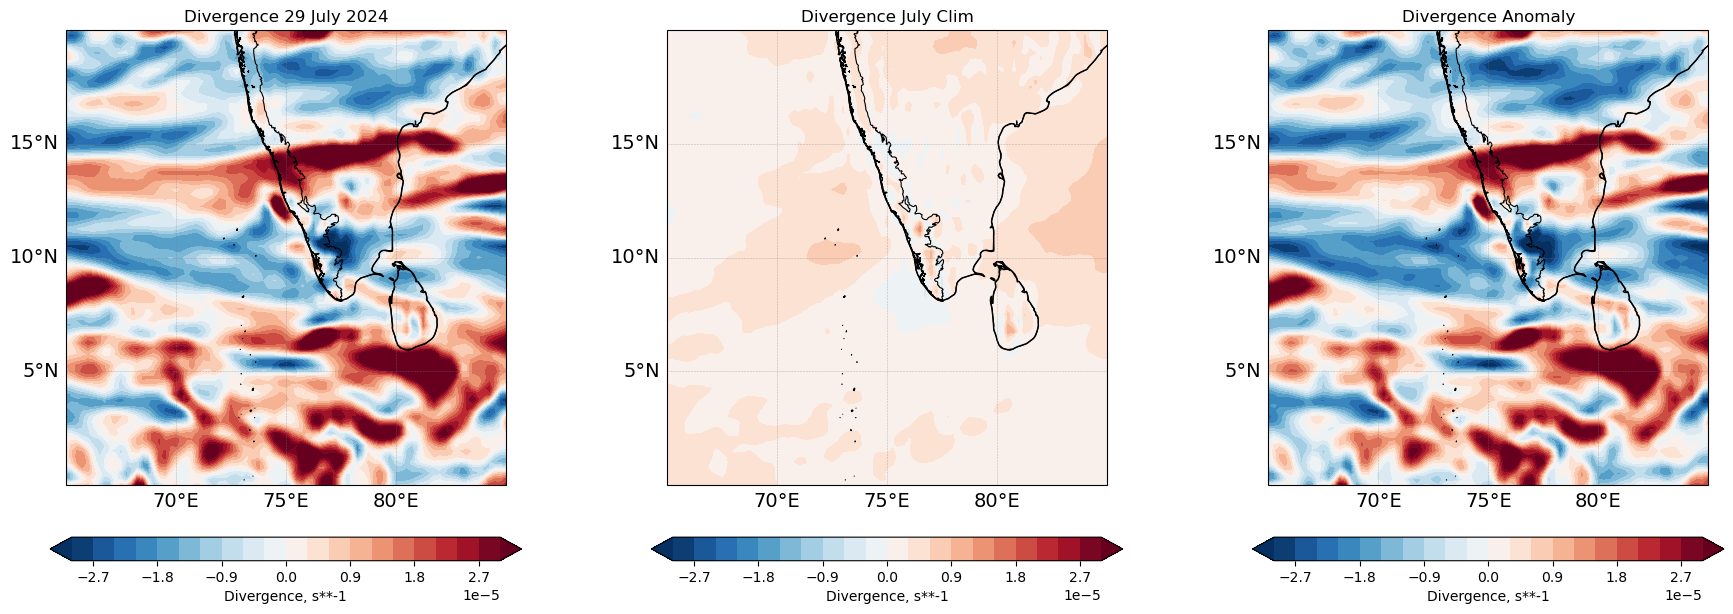

In [16]:
#Divergence
div_200 = ds_daily['d'].sel(isobaricInhPa=200)
div_200_m = ds_monthly_1['d'].sel(isobaricInhPa=200)
div_ano = div_200 - div_200_m

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(div_200 , lon, lat, "Divergence 29 July 2024", "s**-1",ax=axs[0],
                                    levels=np.linspace(-0.3e-4,0.3e-4, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
cf2 = plot_variable_with_shapefiles(div_200_m, lon, lat, "Divergence July Clim", "s**-1", ax=axs[1],
                                    levels=np.linspace(-0.3e-4,0.3e-4, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(div_ano, lon, lat, "Divergence Anomaly", "s**-1", ax=axs[2],
                                    levels=np.linspace(-0.3e-4,0.3e-4, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Divergence, s**-1")
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Divergence, s**-1")
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Divergence, s**-1")
plt.savefig("Div.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
w_500_zonal_avg = w_500.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
wind_shear_zonal_avg = wind_shear.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
ds_mc = xr.DataArray(moisture_convergence, dims=("latitude", "longitude"), coords={"latitude": lat,"longitude": lon})
mc_zonal_avg = ds_mc.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
div_200_zonal_avg = div_200.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
mse_850_zonal_avg = mse_850.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()


In [18]:
w_500_m_zonal_avg = w_500_m.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
wind_shear_m_zonal_avg = wind_shear_m.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
ds_mc_m = xr.DataArray(moisture_convergence_m, dims=("latitude", "longitude"), coords={"latitude": lat,"longitude": lon})
mc_m_zonal_avg = ds_mc_m.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
div_200_m_zonal_avg = div_200_m.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()
mse_850_m_zonal_avg = mse_850_m.sel(latitude=slice(13, 8), longitude = slice(73,77)).mean()


In [19]:
# Define bounds for region of interest
lat_min, lat_max = 8, 13
lon_min, lon_max = 73, 77

# Get 2D lat and lon
lat2d = vimfc['lat']
lon2d = vimfc['lon']

# Create a boolean mask
mask = (lat2d >= lat_min) & (lat2d <= lat_max) & (lon2d >= lon_min) & (lon2d <= lon_max)

# Apply mask to VIMFC
vimfc_region = vimfc.where(mask)
vimfc_m_region = vimfc_m.where(mask)
vimfc_zonal_avg = vimfc_region.mean(dim=['x', 'y'], skipna=True).values
vimfc_m_zonal_avg = vimfc_m_region.mean(dim=['x', 'y'], skipna=True).values

In [20]:
data = {'Parameter': ['w_500', 'ws', 'mc', 'div_200', 'mse','vimfc'],
        'event': [w_500_zonal_avg.values, wind_shear_zonal_avg.values, mc_zonal_avg.values, 
                  div_200_zonal_avg.values,mse_850_zonal_avg.values,vimfc_zonal_avg],
       'clim' : [w_500_m_zonal_avg.values, wind_shear_m_zonal_avg.values, mc_m_zonal_avg.values, 
                 div_200_m_zonal_avg.values,mse_850_m_zonal_avg.values,vimfc_m_zonal_avg]}
df = pd.DataFrame(data)
print(df)

  Parameter                  event                     clim
0     w_500            -0.20096321             -0.053542577
1        ws              40.766018                 33.49141
2        mc  8.176292993123405e-08   -3.654143098823201e-08
3   div_200         -6.6038447e-06            1.8517435e-06
4       mse              340703.03                336971.34
5     vimfc  4.125431481139575e-05  -0.00010614696991805726
